<a href="https://colab.research.google.com/github/roxacarv/edulearn/blob/main/classifica%C3%A7%C3%A3o/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Carregamento dos dados

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import datasets
from mlxtend.plotting import plot_decision_regions

dataset = pd.read_csv("dados_ies_novas_categorias_utf8.csv", index_col=0, encoding="latin-1")

#dataset.drop(dataset[dataset.TIPO_CATEGORIA_ADM == "Especial"].index, inplace=True)
#dataset.drop(dataset[dataset.TIPO_CATEGORIA_ADM == "Pública Municipal"].index, inplace=True)
set(dataset["TIPO_CATEGORIA_ADM"])
#dataset.dropna(subset=["TIPO_CATEGORIA_ADM"], inplace=True)
#print(set(dataset["TIPO_CATEGORIA_ADM"]))
#dataset.to_csv("dados_ies_sem_nan_sem_privadas_especial_utf8.csv")

#dataset.shape

{'Nacional', 'Sub-Nacional'}

# Categorização e mapeamento dos dados de strings para inteiros

In [ ]:
from sklearn import preprocessing
from copy import deepcopy

u = deepcopy(dataset)

le = preprocessing.LabelEncoder()

le.fit(dataset["TIPO_CATEGORIA_ADM"])
dataset["TIPO_CATEGORIA_ADM"]=le.transform(dataset["TIPO_CATEGORIA_ADM"])
le_name_mapping_1 = dict(zip(le.classes_, le.transform(le.classes_)))

le.fit(dataset["REGIAO"])
dataset["REGIAO"]=le.transform(dataset["REGIAO"])
le_name_mapping_2 = dict(zip(le.classes_, le.transform(le.classes_)))

le.fit(dataset["UF"])
dataset["UF"]=le.transform(dataset["UF"])
le_name_mapping_3 = dict(zip(le.classes_, le.transform(le.classes_)))

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

#import json
#a = json.dumps(le_name_mapping_1, default=np_encoder, indent=True, ensure_ascii=False)
#b = json.dumps(le_name_mapping_2, default=np_encoder, indent=True, ensure_ascii=False)
#c = json.dumps(le_name_mapping_3, default=np_encoder, indent=True, ensure_ascii=False)

#ff = '{'
#ff += f'\n"TIPO_CATEGORIA_ADM": [\n{a}\n],\n"REGIAO": [\n{b}\n],\n"UF": [\n{c}\n]'
#ff += '\n}'

#f = open("mapa_categorias.json", "w")
#f.write(ff)
#f.close()

#dataset.to_csv("dados_ies_categorizados.csv")

dataset.shape

(235, 15)


# Predição do dataset utilizando KNN

Processa células não padronizadas (células vazias)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in dataset.columns:
  if dataset[i].dtype == object:
    dataset[i] = le.fit_transform(dataset[i])
  else:
    pass

dataset_encoded = le.fit_transform(dataset.columns)

Normaliza os dados usando StandardScaler e treina o modelo

In [13]:
X = dataset.drop(columns=[
                          "REGIAO", 
                          "TIPO_CATEGORIA_ADM", 
                          "UF", 
                          "CODIGO_IES"
                          ])
y = dataset["TIPO_CATEGORIA_ADM"].values

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y=le.transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)



Cria o objeto KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [15]:
y_pred

array([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0])

Faz a predição

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Confusion matrix:

[[35  6]
 [15 38]]

Classification report:

              precision    recall  f1-score   support

           0       0.70      0.85      0.77        41
           1       0.86      0.72      0.78        53

    accuracy                           0.78        94
   macro avg       0.78      0.79      0.78        94
weighted avg       0.79      0.78      0.78        94

Accuracy:  0.776595744680851


Text(0, 0.5, 'Mean Error')

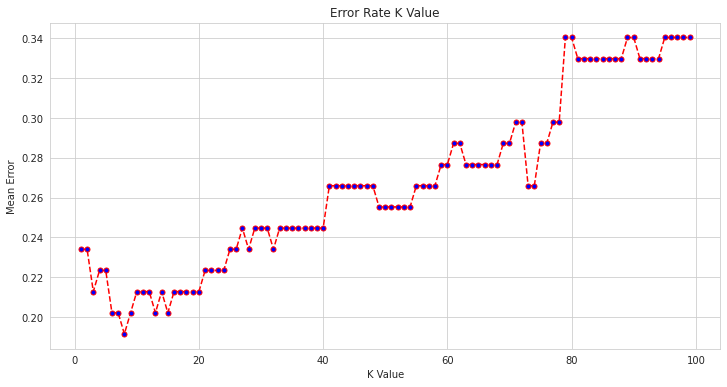

In [18]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 100), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=5)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [19]:
X_train

,NUM_CURSOS,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
2589,1,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
923,110,107.0,38.0,29.0,13.0,6.0,0.000000,0.000000,0.727273,0.000000,0.000000
0,114,92.0,58.0,44.0,17.0,2.0,0.271930,0.429825,0.938596,0.201754,0.201754
42,1,3.0,0.0,0.0,0.0,0.0,4.000000,6.000000,2.000000,2.000000,2.000000
1349,25,2.0,2.0,2.0,0.0,2.0,0.080000,0.240000,0.320000,0.040000,0.040000
...,...,...,...,...,...,...,...,...,...,...,...
1635,43,15.0,5.0,11.0,14.0,1.0,1.744186,2.000000,2.116279,1.162791,1.162791
2384,3,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.333333,0.000000,0.000000
2055,3,1.0,1.0,2.0,0.0,0.0,2.000000,1.666667,1.666667,1.666667,1.666667
2038,15,9.0,1.0,5.0,8.0,0.0,2.866667,4.133333,4.000000,1.933333,1.933333


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


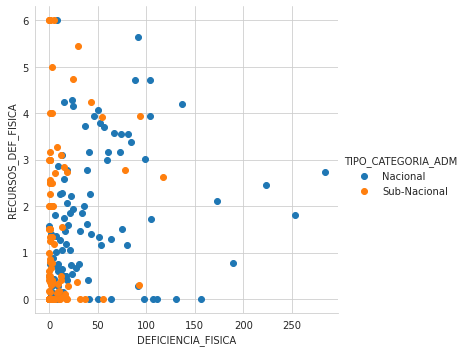

In [20]:
sns.set_style("whitegrid");
sns.FacetGrid(dataset, hue="TIPO_CATEGORIA_ADM", size=5).map(plt.scatter, "DEFICIENCIA_FISICA", "RECURSOS_DEF_FISICA").add_legend();
plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


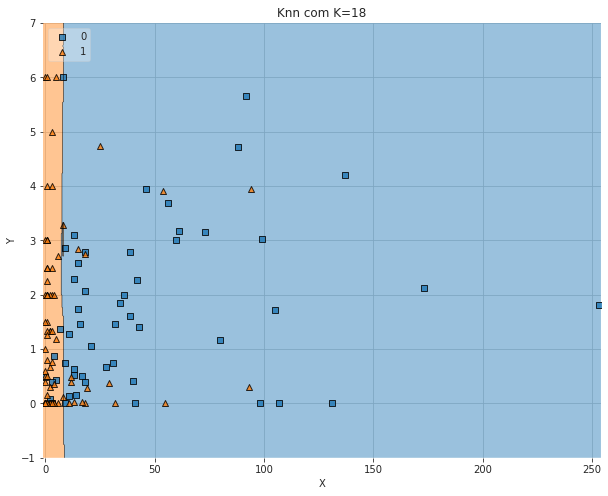

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


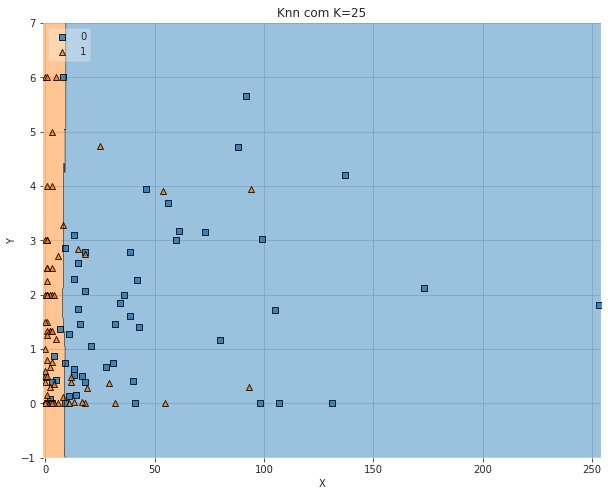

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


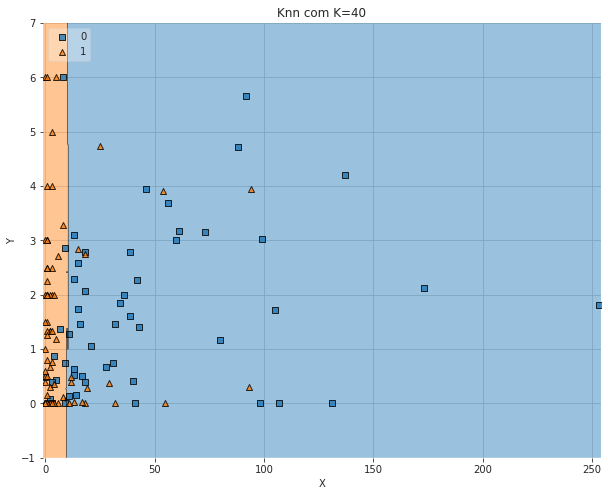

In [10]:

def knn_comparison(X, y, k):
  clf = KNeighborsClassifier(n_neighbors=k)
  clf.fit(X, y)
  value=1.5
  width=0.75
# Plotting decision region
  plt.figure(figsize=(10, 8))
  plot_decision_regions(
     X.to_numpy(), 
     y, 
     clf=clf,
     legend=2
     )
# Adding axes annotations
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title("Knn com K=" + str(k))
  plt.show()

for i in [18, 25, 40]:
  knn_comparison(X_train, y_train, i)

Accuracy: 0.7659574468085106
Precision: 0.7787716505041733
Recall: 0.7659574468085106


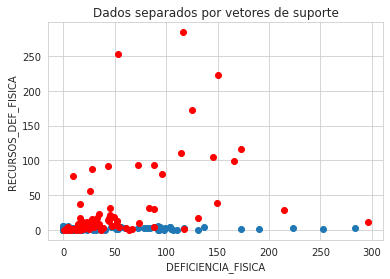

In [21]:
from sklearn import svm
from sklearn import metrics

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average="weighted"))
print("Recall:",metrics.recall_score(y_test, y_pred, average="weighted"))

support_vector_indices = clf.support_
#print(support_vector_indices)

support_vector_classes = clf.n_support_
#print(support_vector_classes)

support_vectors = clf.support_vectors_
plt.scatter(X_train["DEFICIENCIA_FISICA"], X_train["RECURSOS_DEF_FISICA"])
plt.scatter(support_vectors[:,0], support_vectors[:,1], color="red")
plt.title("Dados separados por vetores de suporte")
plt.xlabel("DEFICIENCIA_FISICA")
plt.ylabel("RECURSOS_DEF_FISICA")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

p_grid = [
          {'C': [0.5, 1, 10, 100],
           'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
           'kernel': ['rbf']},
]

optimal = GridSearchCV(
    svm.SVC(),
    p_grid,
    cv=5,
    scoring='accuracy',
    verbose=0
)

optimal.fit(X_train, y_train)
print(optimal.best_params_)

{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}


Accuracy: 0.723404255319149
Precision: 0.6549137871948771
Recall: 0.723404255319149


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


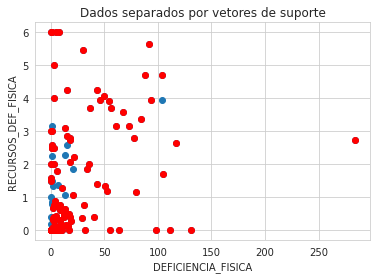

In [ ]:
clf = svm.SVC(kernel='rbf', C=0.5, gamma=0.1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average="weighted"))
print("Recall:",metrics.recall_score(y_test, y_pred, average="weighted"))

support_vector_indices = clf.support_
#print(support_vector_indices)

support_vector_classes = clf.n_support_
#print(support_vector_classes)

support_vectors = clf.support_vectors_
plt.scatter(X_train["DEFICIENCIA_FISICA"], X_train["RECURSOS_DEF_FISICA"])
plt.scatter(support_vectors[:,0], support_vectors[:,1], color="red")
plt.title("Dados separados por vetores de suporte")
plt.xlabel("DEFICIENCIA_FISICA")
plt.ylabel("RECURSOS_DEF_FISICA")
plt.show()